# Setup and Imports

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 101

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

RS = 35577 # global random state seed
data_path = './data-raw/'

In [3]:
df_data = pd.read_csv(data_path + 'bearing_signals.csv', 
                      usecols=['experiment_id', 'bearing_1_id', 'bearing_2_id', 'timestamp', 'a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w']) 
                      # skippin hz col as it can be clauclatd from rpm/60

# Helper functions

In [40]:
def iqr(series):
    return series.quantile(0.75) - series.quantile(0.25)

# Data Transformation

In [ ]:
def remove_outliers(df):
    

# First Look

In [7]:
'size MB: ', df_data.memory_usage().sum()/2**20
'shape', df_data.shape
df_data.head(3)
df_data.info(verbose=True)
df_data.describe().T
'isnull', df_data.isnull().sum()

('size MB: ', 939.85302734375)

('shape', (10265700, 12))

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w
0,1,0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.0,0.000006
1,1,0,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.0,0.000243
2,1,0,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.0,0.000369


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10265700 entries, 0 to 10265699
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   experiment_id  int64  
 1   bearing_1_id   int64  
 2   bearing_2_id   int64  
 3   timestamp      float64
 4   a1_x           float64
 5   a1_y           float64
 6   a1_z           float64
 7   a2_x           float64
 8   a2_y           float64
 9   a2_z           float64
 10  rpm            float64
 11  w              float64
dtypes: float64(9), int64(3)
memory usage: 939.9 MB


,count,mean,std,min,25%,50%,75%,max
experiment_id,10265700.0,56.588971,3.231361e+01,1.000000e+00,29.000000,56.000000,85.000000,112.000000
bearing_1_id,10265700.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
bearing_2_id,10265700.0,56.588971,3.231361e+01,1.000000e+00,29.000000,56.000000,85.000000,112.000000
timestamp,10265700.0,15.567967,9.425589e+00,0.000000e+00,7.638000,15.276333,22.914333,55.499667
a1_x,10265700.0,-0.220073,1.824082e+00,-1.604771e+01,-1.041087,-0.175320,0.594250,15.600872
a1_y,10265700.0,-0.048326,1.450662e+00,-1.887183e+01,-0.607370,-0.039563,0.528244,16.142936
a1_z,10265700.0,-0.052549,1.768919e+00,-1.633967e+01,-0.878530,-0.014243,0.850044,16.407213
a2_x,10265700.0,-0.312419,2.553113e+00,-1.765083e+01,-1.602094,-0.374838,0.852418,19.166852
a2_y,10265700.0,-0.087583,2.631378e+00,-1.873959e+01,-1.247228,0.002226,0.867233,22.492407
a2_z,10265700.0,0.071022,2.700098e+00,-2.296248e+01,-1.040389,0.055715,1.151820,25.963643


('isnull',
 experiment_id    0
 bearing_1_id     0
 bearing_2_id     0
 timestamp        0
 a1_x             0
 a1_y             0
 a1_z             0
 a2_x             0
 a2_y             0
 a2_z             0
 rpm              0
 w                0
 dtype: int64)

In [15]:
'Number of unique experiments: ', df_data['experiment_id'].nunique()

'Number of Unique Bearings in slot 1: ', df_data['bearing_1_id'].nunique()
'bearing_1_id:', df_data.loc[0, 'bearing_1_id']

'Number of Unique Bearings in slot 2: ', df_data['bearing_2_id'].nunique()

('Number of unique experiments: ', 112)

('Number of Unique Bearings in slot 1: ', 1)

('bearing_1_id:', 0)

('Number of Unique Bearings in slot 2: ', 112)

In [19]:
df_data.groupby(['experiment_id'])['bearing_2_id'].nunique()

experiment_id
1      1
2      1
3      1
4      1
5      1
      ..
108    1
109    1
110    1
111    1
112    1
Name: bearing_2_id, Length: 112, dtype: int64

In [32]:
'1 experiment is testing 1 bearing', (df_data.groupby(['experiment_id'])['bearing_2_id'].nunique() == 1).all()

('1 experiment is testing 1 bearing', True)

# Data Distribution

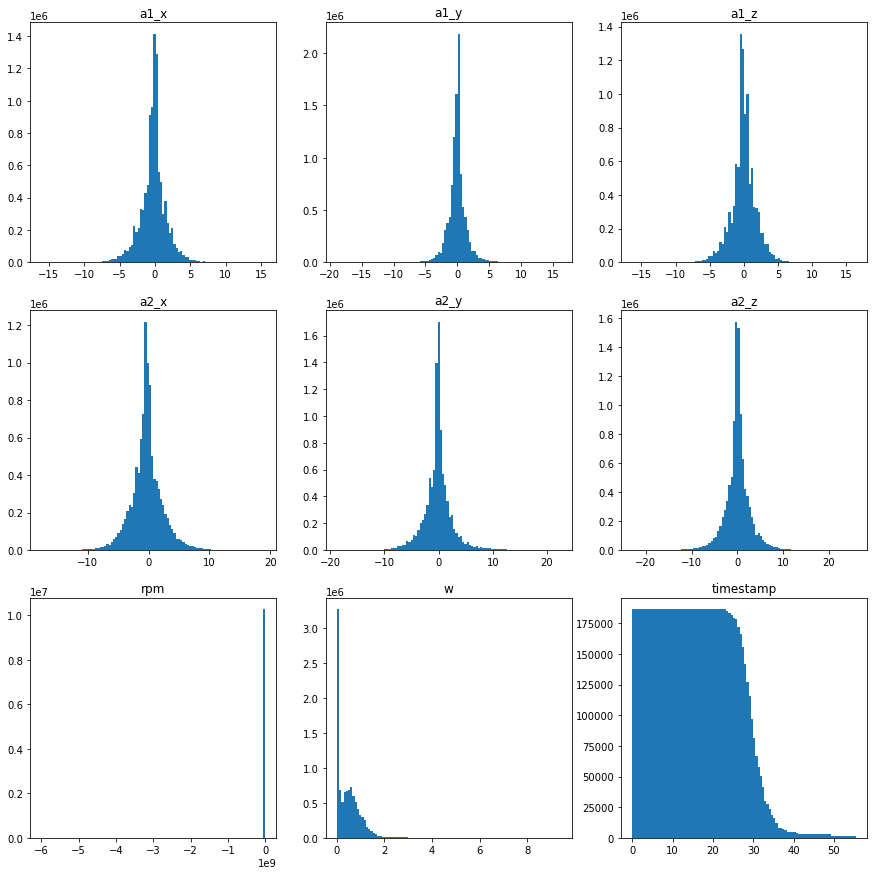

In [34]:
df_plt = df_data#.sample(20000, random_state=RS)
axs = plt.subplots(3, 3, figsize=(15,15))[1].flatten()

for i_col, col in enumerate(['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'timestamp']):
    ax = axs[i_col]
    _ = ax.hist(df_plt[col], bins=100)
    _ = ax.set_title(col)    

## "rpm" and "w" distribution in log scale

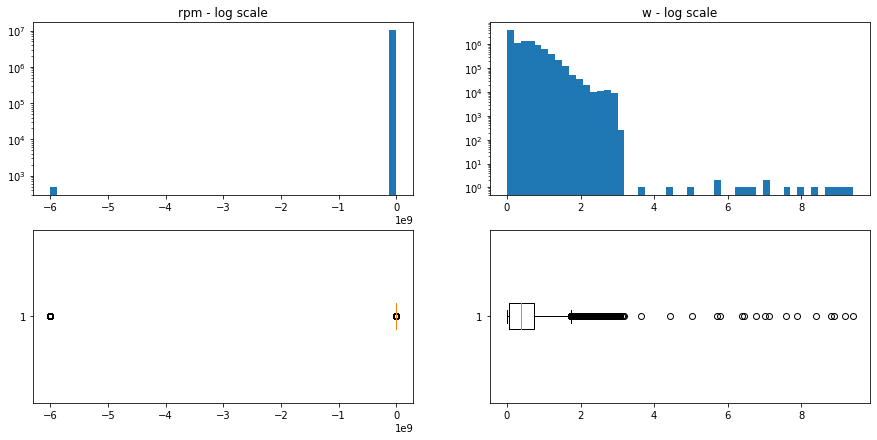

In [37]:
axs = plt.subplots(2, 2, figsize=(15,7))[1]

for i_col, col in enumerate(['rpm','w']):
    ax = axs[0, i_col]
    _ = ax.hist(df_plt[col], bins=50, log=True)
    _ = ax.set_title(col + ' - log scale')

for i_col, col in enumerate(['rpm','w']):
    ax = axs[1, i_col]
    _ = ax.boxplot(df_plt[col], vert=False)

## "rpm" - removing outliers

24    659
21    545
19    484
8     482
40    474
15    425
36    384
11    372
81    343
14    273
17    243
23    202
29    187
Name: experiment_id, dtype: int64

('% of experiments with outliers: ', 0.11607142857142858)

('% of RPM outliers: ', 0.0004941699056079955)

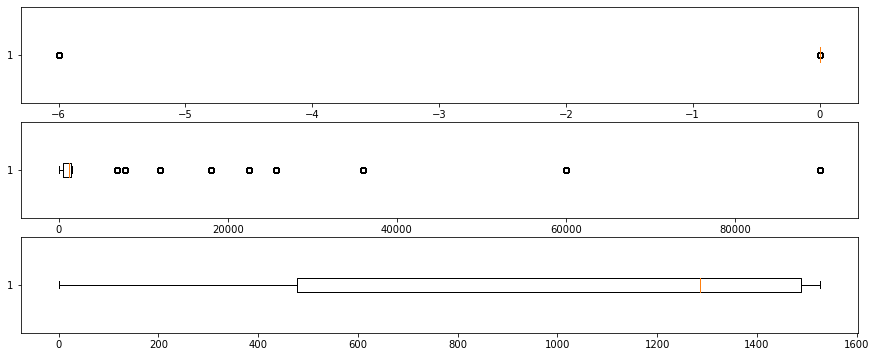

In [62]:
axs = plt.subplots(3, 1, figsize=(15,6))[1].flatten()

df_plt = df_data['rpm']
_ = axs[0].boxplot(df_plt, vert=False)

df_plt = df_plt.loc[df_plt > -5e+9]
_ = axs[1].boxplot(df_plt, vert=False)

rpm_iqr = iqr(df_data['rpm'])
df_plt = df_data['rpm'].loc[df_data['rpm'].between(-5 * rpm_iqr, 5 * rpm_iqr)]
_ = axs[2].boxplot(df_plt, vert=False)

df_rpm_irq_outlier = df_data.loc[~df_data.index.isin(df_plt.index)]

df_rpm_irq_outlier['experiment_id'].value_counts()
'% of experiments with outliers: ', len(df_rpm_irq_outlier['experiment_id'].value_counts())/len(df_data['experiment_id'].value_counts())
'% of RPM outliers: ', len(df_rpm_irq_outlier)/len(df_data)

## "w" - removing outliers

20     116236
25      82563
24      74388
30      66506
104     56314
        ...  
109      1589
72       1475
73       1462
92       1430
87       1391
Name: experiment_id, Length: 112, dtype: int64

('% of experiments with outliers: ', 1.0)

('% of w outliers: ', 0.1226696669491608)

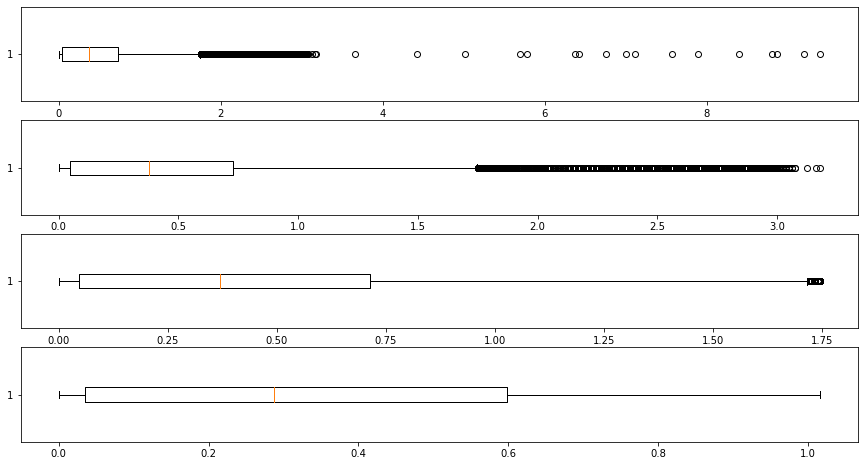

In [63]:
axs = plt.subplots(4, 1, figsize=(15,8))[1].flatten()

df_plt = df_data['w']
_ = axs[0].boxplot(df_plt, vert=False)

df_plt = df_plt.loc[df_plt <3.5]
_ = axs[1].boxplot(df_plt, vert=False)

df_plt = df_plt.loc[df_plt <1.75]
_ = axs[2].boxplot(df_plt, vert=False)

w_iqr = iqr(df_data['w'])
df_plt = df_data['w'].loc[df_data['w'].between(-1.5 * w_iqr, 1.5 * w_iqr)]
_ = axs[3].boxplot(df_plt, vert=False)

df_w_irq_outlier = df_data.loc[~df_data.index.isin(df_plt.index)]

df_w_irq_outlier['experiment_id'].value_counts()
'% of experiments with outliers: ', len(df_w_irq_outlier['experiment_id'].value_counts())/len(df_data['experiment_id'].value_counts())
'% of w outliers: ', len(df_w_irq_outlier)/len(df_data)

,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,timestamp
879985,-2.195443,-0.039563,-1.358690,1.324439,0.002226,1.450758,1487.603306,0.084478,7.528333
5039766,-0.367713,1.096051,-0.782499,0.569205,-0.574445,0.753237,1512.605042,0.502098,11.922000
4154706,1.075231,0.055072,-1.550754,-6.416714,-4.418920,0.653591,1090.909091,1.244829,4.402000
2755385,-0.271517,1.758493,-0.014243,-0.941264,0.867233,-3.531536,967.741935,0.882051,4.061667
1201585,-0.079124,-0.039563,0.273852,0.191588,0.963345,0.553945,578.778135,0.061214,0.728333
...,...,...,...,...,...,...,...,...,...
8272374,2.037194,1.569224,0.754012,-6.227905,1.347793,-3.431890,1285.714286,0.543777,5.858000
9112744,-0.560106,0.149706,-0.494403,0.285992,0.194450,-0.542160,279.503106,0.777094,0.981333
10048496,-0.752498,-2.310791,0.369884,-0.186030,-1.151116,-2.236140,1208.053691,0.070453,21.498667
9023819,0.209465,0.055072,-0.398371,-1.224477,0.194450,0.653591,254.957507,0.000417,32.039667


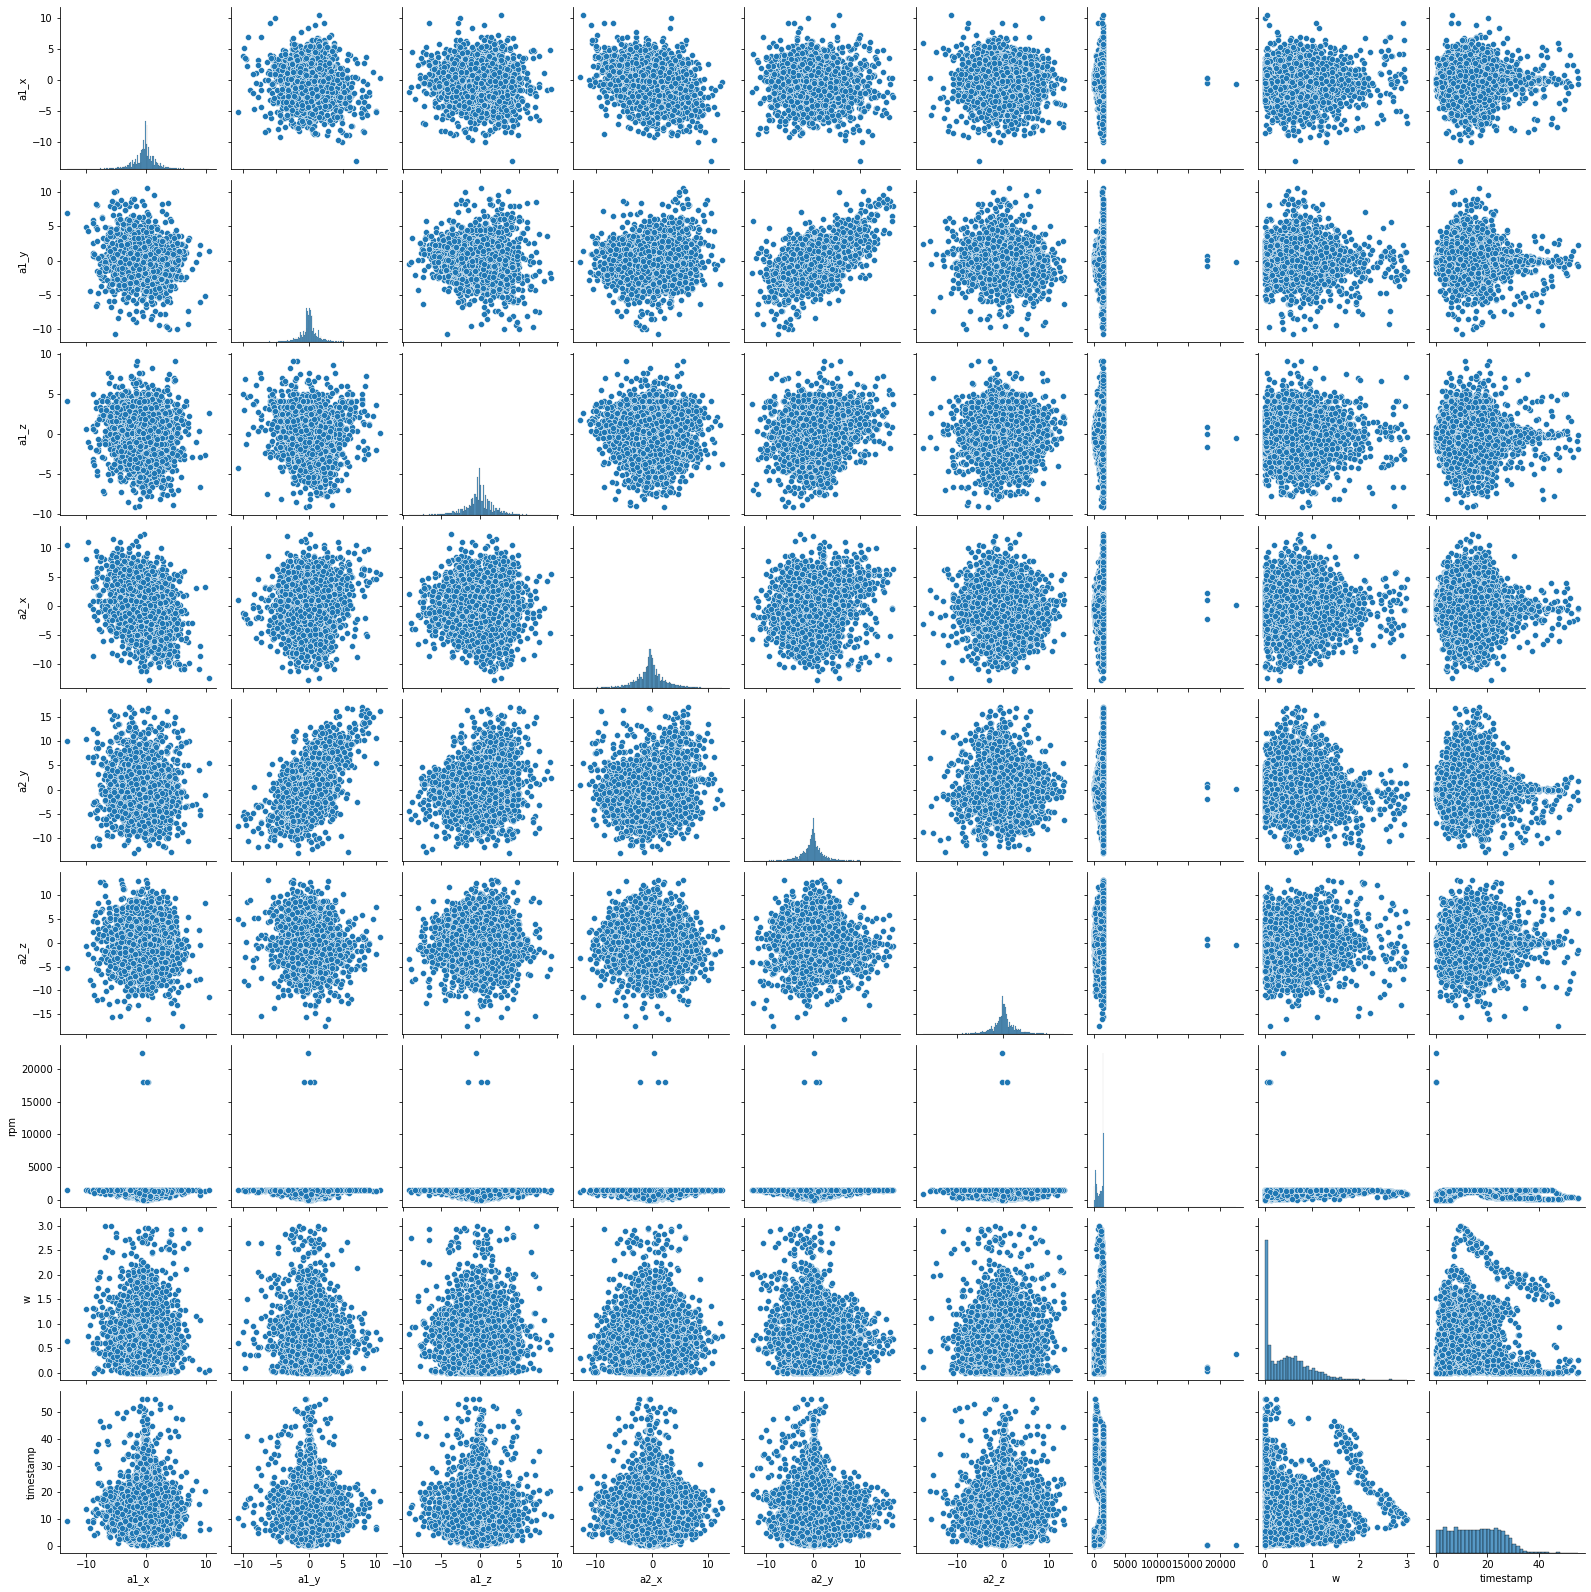

In [70]:
df_plt = df_data[['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'timestamp']].sample(10000)
sns.pairplot(df_plt)

In [ ]:
# https://stats.stackexchange.com/questions/235808/binary-classification-with-strongly-unbalanced-classes